In [15]:
import pandas as pd
import yfinance as yf


In [76]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

def get_data_from_yfinance(symbol, start_date, end_date):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    try:
        # Fetch historical stock data for the specified symbol and date range from Yahoo Finance
        stock_data = yf.download(symbol, start=start_date, end=end_date)
        
        # Reset the index and format the '_id' field as a string
        stock_data.reset_index(inplace=True)
        
        return stock_data
    except Exception as e:
        print(f"Error fetching data for {symbol} from {start_date} to {end_date}: {e}")
df = get_data_from_yfinance("AAPL","2024-02-23","2024-02-27")
df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2024-02-23,185.009995,185.039993,182.229996,182.520004,182.520004,45074500
1,2024-02-26,182.240005,182.759995,180.649994,181.160004,181.160004,40715200


In [75]:
from pymongo import MongoClient

def create_update_collections(connection_string, database):
    symbols_list = ["AAPL"]

    """cretes data frame for given symbol list starting from 2015-01-01 to now+1 (now is included)
    """
    client = MongoClient(connection_string)
    db = client[database]
        

    for symbol in symbols_list:

        collection = db[symbol]
        most_recent_document = collection.find_one({}, sort=[('_id', -1)])
        if most_recent_document:
            most_recent_id = most_recent_document["_id"]
            most_recent_date = datetime.strptime(most_recent_id, "%Y-%m-%d")
            one_day_later = most_recent_date + timedelta(days=1)
            start_date = one_day_later.strftime("%Y-%m-%d")

            now = datetime.now()
            tomorrow = now + timedelta(days=1)
            end_date = tomorrow.strftime("%Y-%m-%d")
        else:
            start_date = "2015-01-01"
            tomorrow = datetime.now() + timedelta(days=1)
            end_date = tomorrow.strftime("%Y-%m-%d")


        
        data = get_data_from_yfinance(symbol, start_date,end_date)

        data['_id'] = pd.to_datetime(data['Date']).dt.strftime("%Y-%m-%d")

        # Drop the original 'Date' column
        data = data.drop(columns=['Date'])

        # Convert the DataFrame to a list of dictionaries
        data_list = data.to_dict(orient='records')

        # Insert the data into the MongoDB collection
        collection.insert_many(data_list)

    client.close()


create_update_collections("mongodb://127.0.0.1:27017/","stockdata")    



[*********************100%%**********************]  1 of 1 completed


In [74]:
a = datetime().now()

TypeError: function missing required argument 'year' (pos 1)

In [72]:
current_time = datetime.now().strftime("%Y-%m-%d")
print(type(current_time))
print(current_time)


<class 'str'>
2024-02-27


datetime.timedelta

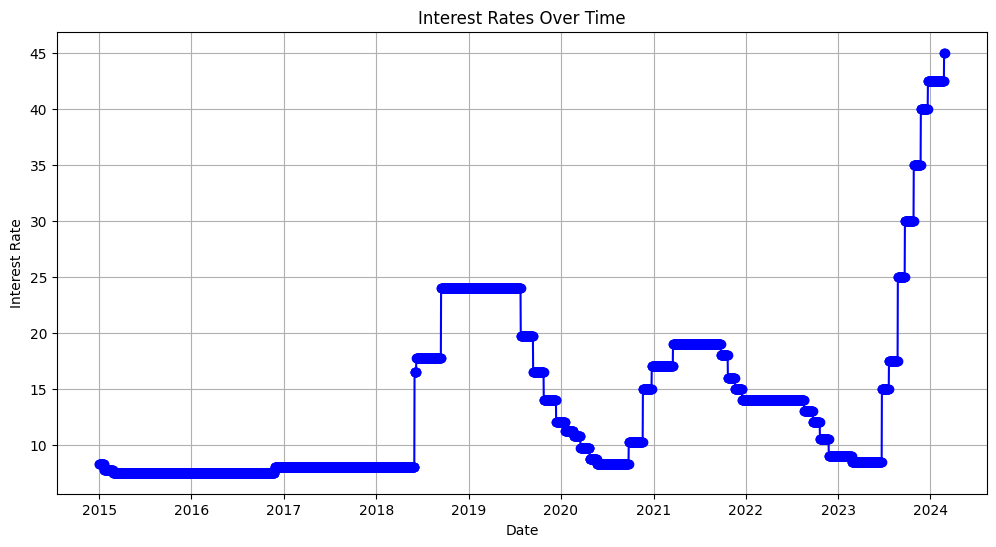

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

# Constants
MONGO_URI = "mongodb://127.0.0.1:27017/"
DB_NAME = "stockdata"
COLLECTION_NAME = "interest"

# Connect to MongoDB
client = MongoClient(MONGO_URI)
db = client[DB_NAME]
collection = db[COLLECTION_NAME]

# Retrieve data from MongoDB
data = list(collection.find({}, {'_id': 1, 'Rate': 1}))

# Convert data to DataFrame
df = pd.DataFrame(data)
df['_id'] = pd.to_datetime(df['_id'], format='%Y-%m-%d')

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['_id'], df['Rate'], marker='o', linestyle='-', color='b')
plt.title('Interest Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.grid(True)
plt.show()

# Close the MongoDB connection
client.close()
